# Computer Networks - TCP Congestion Control 
### Zhivar Sourati - 810196502
### Mohsen Fayyaz - 810196650

In [19]:
import os
import matplotlib.pyplot as plt
from os import system, name
import sys
from IPython.display import clear_output
import pandas as pd
import math

TCP_ALGORITHMS = ["TCP/Newreno", "TCP", "TCP/Vegas"]
cwndResults = dict()
goodPutResults = dict()
rttResults = dict()
dropResults = dict()

def cls():
    # for windows
    if name == 'nt':
        _ = system('cls')

        # for mac and linux(here, os.name is 'posix')
    else:
        _ = system('clear')

    clear_output(wait=True)
    
    
def retrieveCwndChanges(fileAddress):
    cwndChanges = list()
    with open(fileAddress, "r") as traceFile:
        for line in traceFile:
            lineWords = ' '.join(line.split()).strip().split(" ")
            cwndChanges.append([float(lineWords[0]), float(lineWords[1]), float(lineWords[2])])
    return cwndChanges


def runNs(tcpAlgorithm):
    print("Loading...")
    os.system('ns main.tcl ' + tcpAlgorithm + ' > tmp')
    cls()
    print(open('tmp', 'r').read())
    os.remove('tmp')

def getDropTimes():
    tcp0Loss = []
    tcp1Loss = []
    with open('./output/trace.tr') as tracefile:
        for line in tracefile:
            data = line.strip().split()
            if data[0] == 'd':
                if data[7] == '1':
                    tcp0Loss.append(data[1])
                else:
                    tcp1Loss.append(data[1])
    return tcp0Loss, tcp1Loss


def segmentCount(times):
    segmentsCount = [0] * 1000
    for time in times:     
        segmentsCount[math.floor(float(time))] += 1
    return segmentsCount


def retrieveDrops():
    tcp0LossTimes, tcp1LossTimes = getDropTimes()
    tcp0LossCountInTime = segmentCount(tcp0LossTimes)
    tcp1LossCountInTime = segmentCount(tcp1LossTimes)
    result = list()
    for i in range(0, len(tcp0LossCountInTime)):
        result.append([i, tcp0LossCountInTime[i], tcp1LossCountInTime[i]])
    return result

def copyResults(tcpAlgorithm, i):
    os.system('cp output/cwnd.out results/CWND_' + tcpAlgorithm.replace("/", "") + "_" + str(i))
    os.system('cp output/gp.out results/GOODPUT_' + tcpAlgorithm.replace("/", "") + "_" + str(i))
    os.system('cp output/rtt.out results/RTT_' + tcpAlgorithm.replace("/", "") + "_" + str(i))
    os.system('cp ./output/trace.tr results/LOSS_' + tcpAlgorithm.replace("/", "") + "_" + str(i))
    
def processSimulation():
    for tcpAlgorithm in TCP_ALGORITHMS:
        for i in range(0, 10):
            runNs(tcpAlgorithm)
            copyResults(tcpAlgorithm, i);
            newCwndDF = pd.DataFrame(retrieveCwndChanges("output/cwnd.out"), columns=['time','tcp0','tcp1'])
            newGoodPutDF = pd.DataFrame(retrieveCwndChanges("output/gp.out"), columns=['time','tcp0','tcp1'])
            newRttDF = pd.DataFrame(retrieveCwndChanges("output/rtt.out"), columns=['time','tcp0','tcp1'])
            newDropDF = pd.DataFrame(retrieveDrops(), columns=['time','tcp0','tcp1'])
            if(i == 0):
                cwndDF = newCwndDF
                goodPutDF = newGoodPutDF
                rttDF = newRttDF
                dropDF = newDropDF
            else:
                cwndDF = cwndDF.add(newCwndDF, fill_value=0)
                goodPutDF = goodPutDF.add(newGoodPutDF, fill_value=0)
                rttDF = rttDF.add(newRttDF, fill_value=0)
                dropDF = dropDF.add(newDropDF, fill_value=0)
            
        cwndResults[tcpAlgorithm] = cwndDF / 10
        goodPutResults[tcpAlgorithm] = goodPutDF / 10
        rttResults[tcpAlgorithm] = rttDF / 10
        dropResults[tcpAlgorithm] = dropDF / 10
        
    print("Simulation Finished.")


# TCP is Tahoe

In [20]:
processSimulation()

You chose TCP/Vegas
1->2 variable delay: 15
3->5 variable delay: 23
final ack0: 8332, final seq num0: 8336
final ack1: 4165, final seq num1: 4167

Simulation Finished.


In [21]:
# import jtplot module in notebook
from jupyterthemes import jtplot
# jtplot.style(context='talk', fscale=1.4, spines=True, gridlines='--')
jtplot.reset()

def graphFlows(inPlt, cwndChanges, label="No Label", title="No Title"):
#     cwndChanges = shrinkLargeList(cwndChanges)
    timeList = cwndChanges[["time"]]
    tcp0Cwnd = cwndChanges[["tcp0"]]
    tcp1Cwnd = cwndChanges[["tcp1"]]
#     print(timeList)
#     print(tcp0Cwnd)
#     print(tcp1Cwnd)
#     plt.plot(timeList, tcp0Cwnd, '-o', label=label + "(Flow 1)", linewidth=2)
#     plt.plot(timeList, tcp1Cwnd, '-o', label=label + "(Flow 2)", linewidth=2)
    inPlt.plot(timeList, tcp0Cwnd, label=label + "(Flow 1)", linewidth=0.8)
    inPlt.plot(timeList, tcp1Cwnd, label=label + "(Flow 2)", linewidth=0.8)
    
    inPlt.set_title(title)
    inPlt.set(xlabel='Time', ylabel=title)
#     inPlt.mset(xlabel='Time', ylabel=title)
#     plt.set_xlabel("Time")
#     plt.set_ylabel(title)
    inPlt.legend(loc="upper left")

#     plt.setp(plt.gca().get_xticklabels(), rotation=90, horizontalalignment='right')
#     plt.gca().set_xticks(plt.gca().get_xticks()[::5])
#     plt.gca().set_yticks(plt.gca().get_yticks()[::10])


def plotResults(results, title):
    fig = plt.figure(figsize=(20, 10))
    for tcpAlgorithm in TCP_ALGORITHMS:
        graphFlows(plt.gca(), results[tcpAlgorithm], label=tcpAlgorithm, title=title)
    
    print("plotting...")
    plt.show()
    
    fig = plt.figure(figsize=(20, 5))
    for tcpAlgorithm in TCP_ALGORITHMS:
        plt.subplot(1, 3, TCP_ALGORITHMS.index(tcpAlgorithm) + 1)
        graphFlows(plt.gca(), results[tcpAlgorithm], label=tcpAlgorithm, title=title)
    plt.show()
    
    
def shrinkLargeList(myList, newSize = 200):
    # more then 100000 points makes it unusable slow to plot
    step = int(len(myList) / newSize)
    if(step == 0):
        step = 1
    return myList[0::step]

# CWND)

plotting...


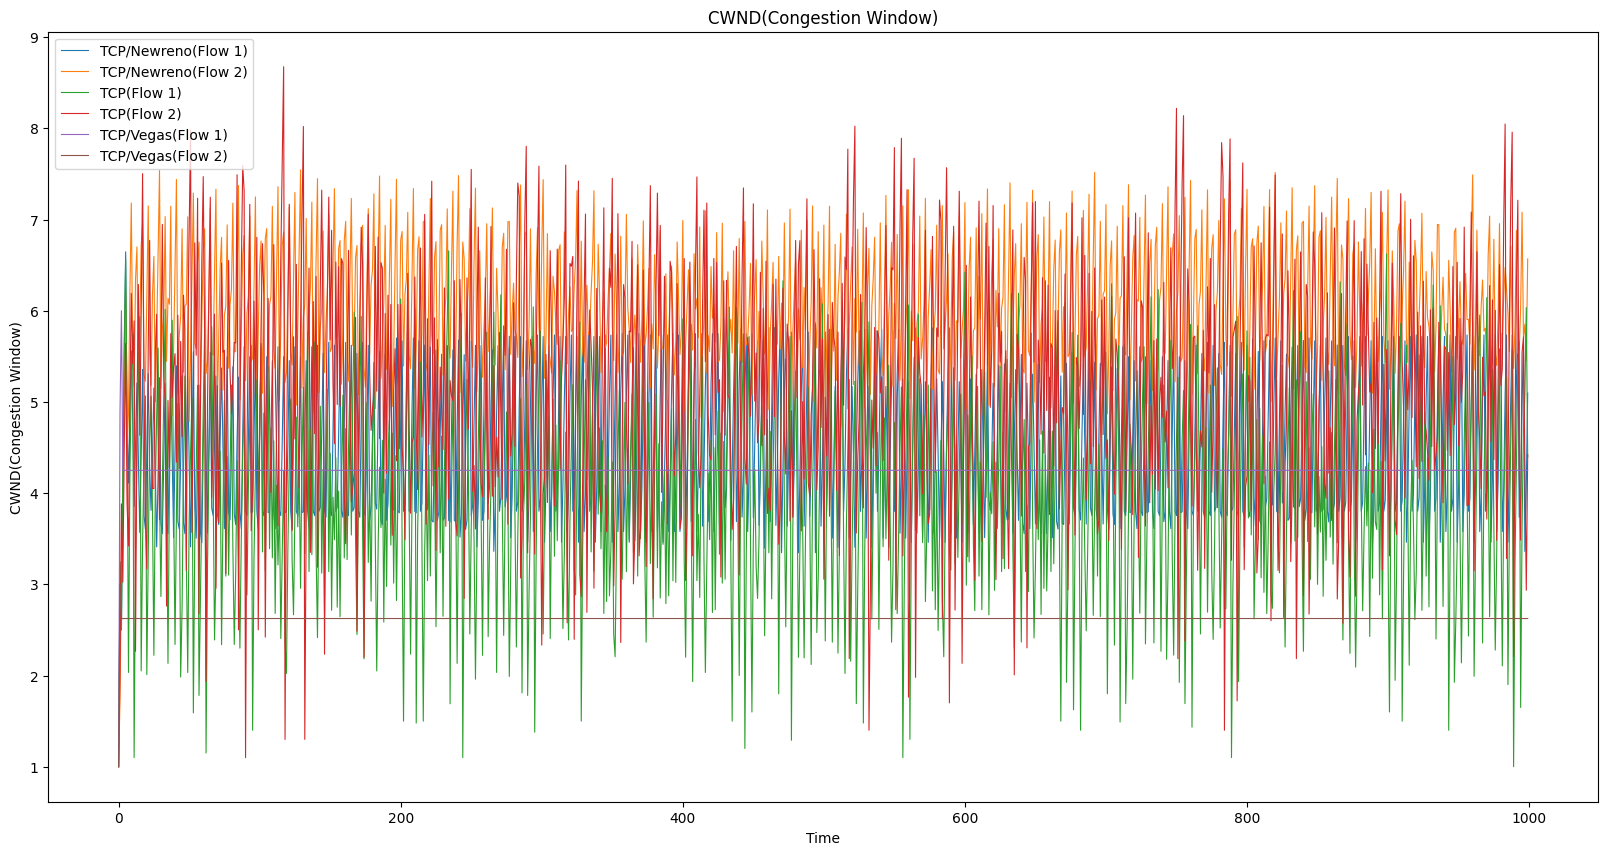

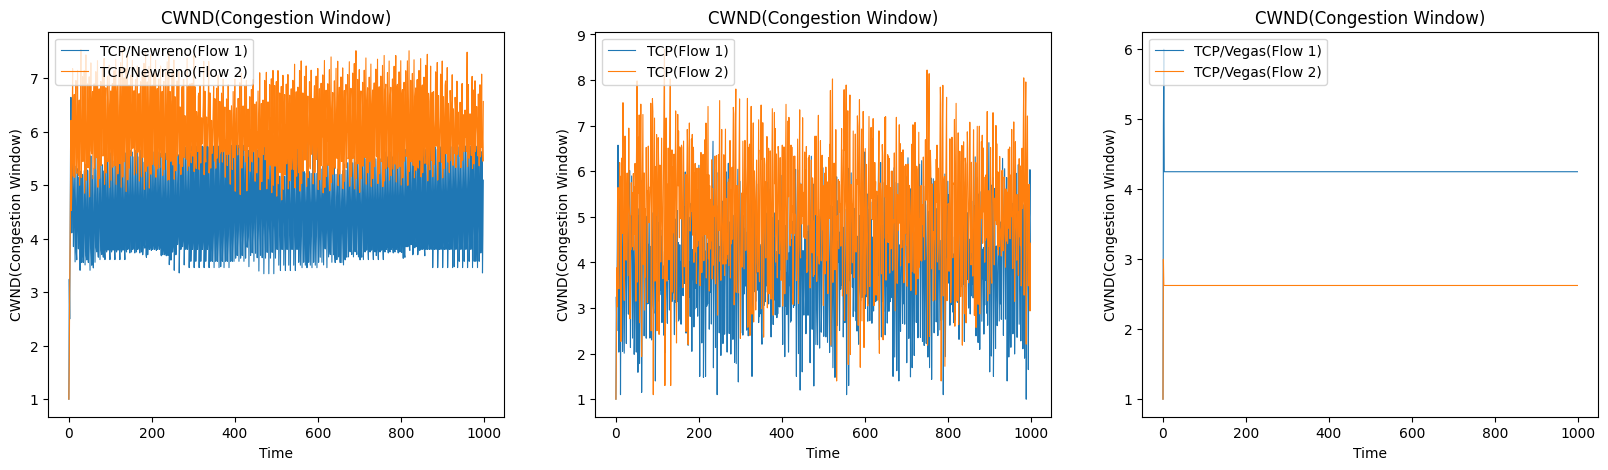

In [22]:
plotResults(cwndResults, "CWND(Congestion Window)")

# Goodput)

plotting...


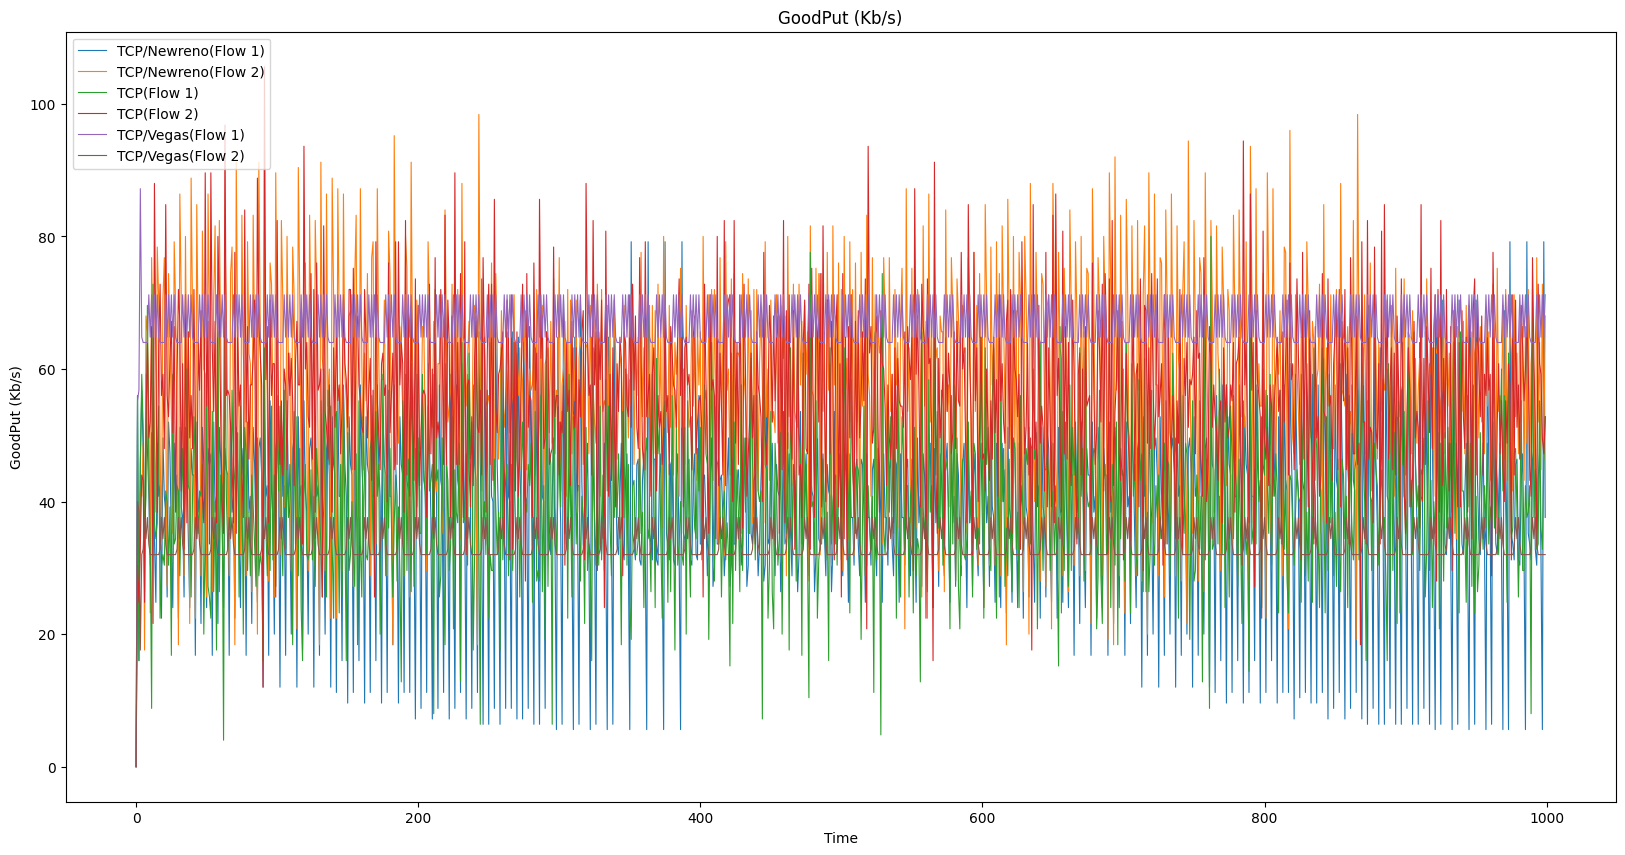

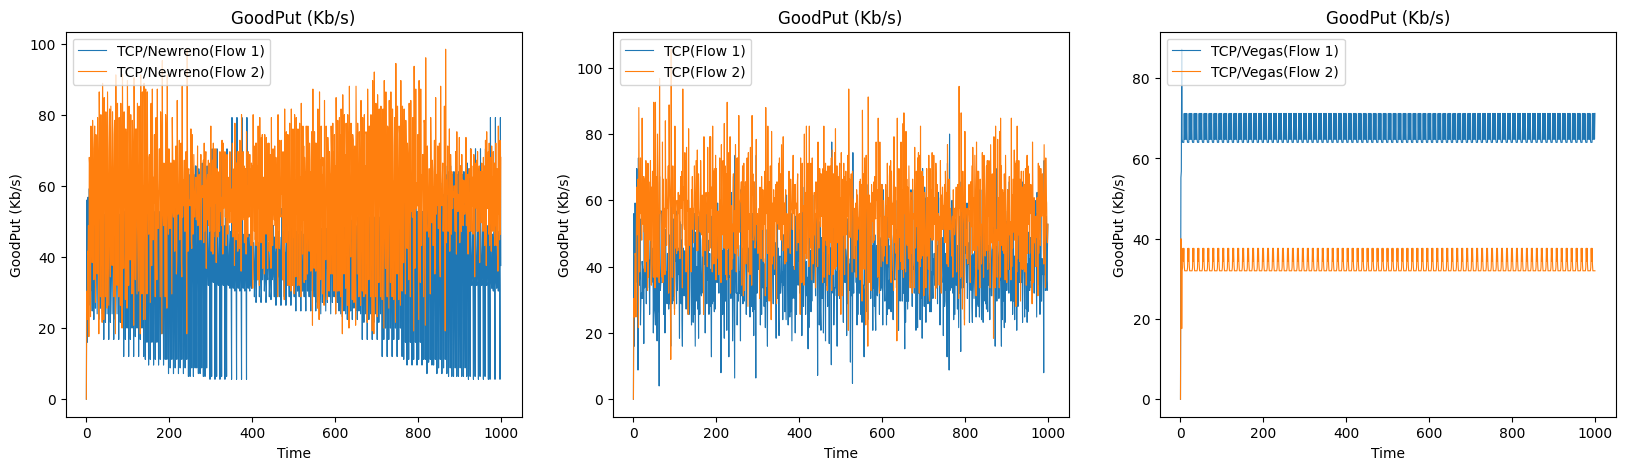

In [23]:
plotResults(goodPutResults, "GoodPut (Kb/s)")

# Packet Loss)


plotting...


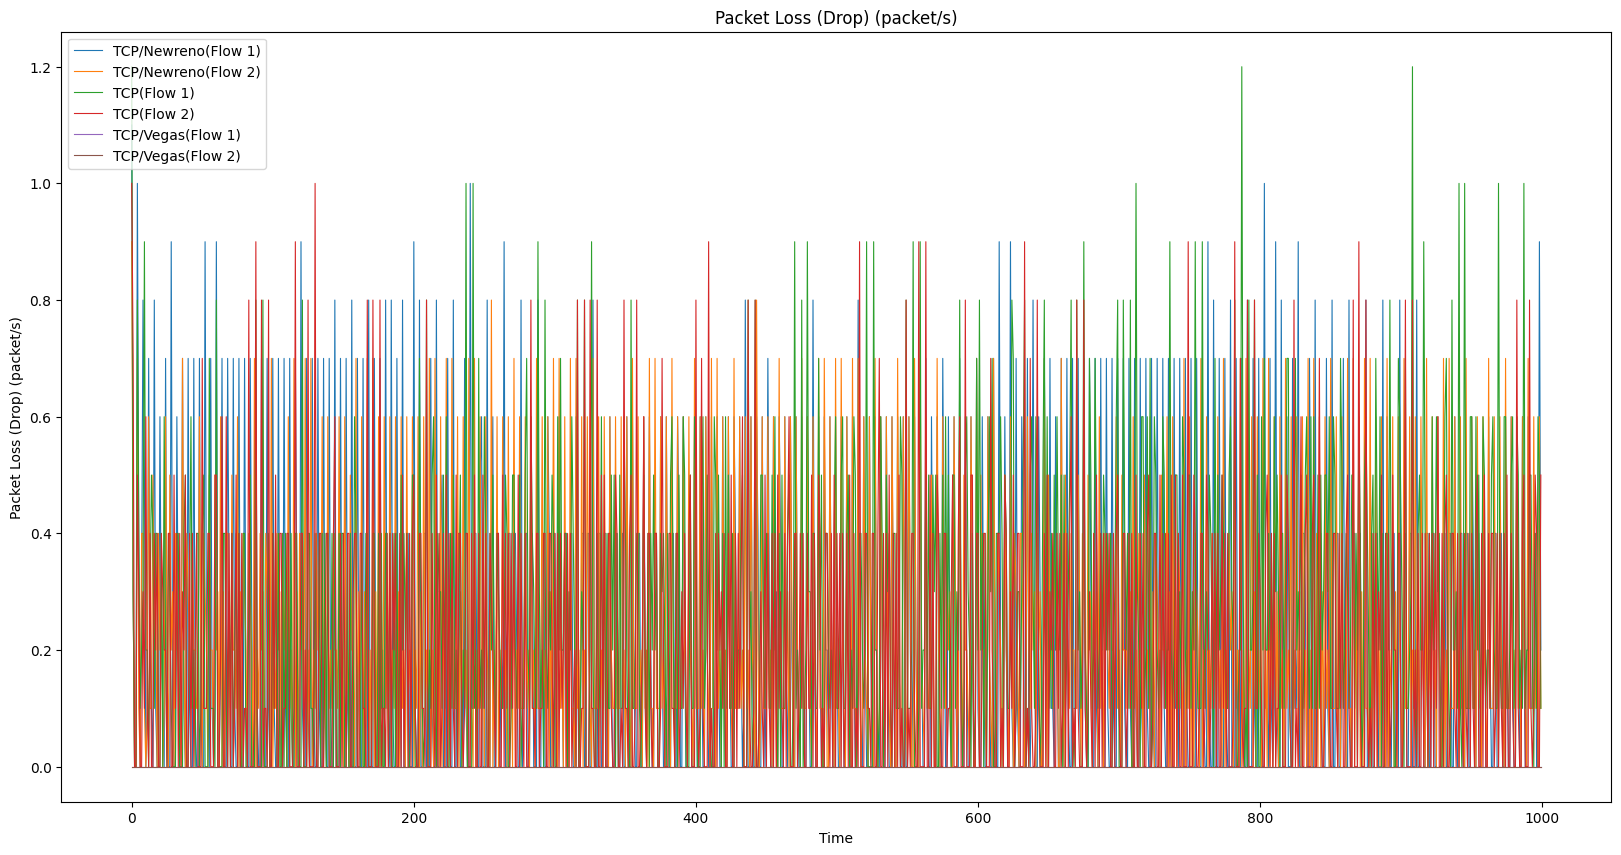

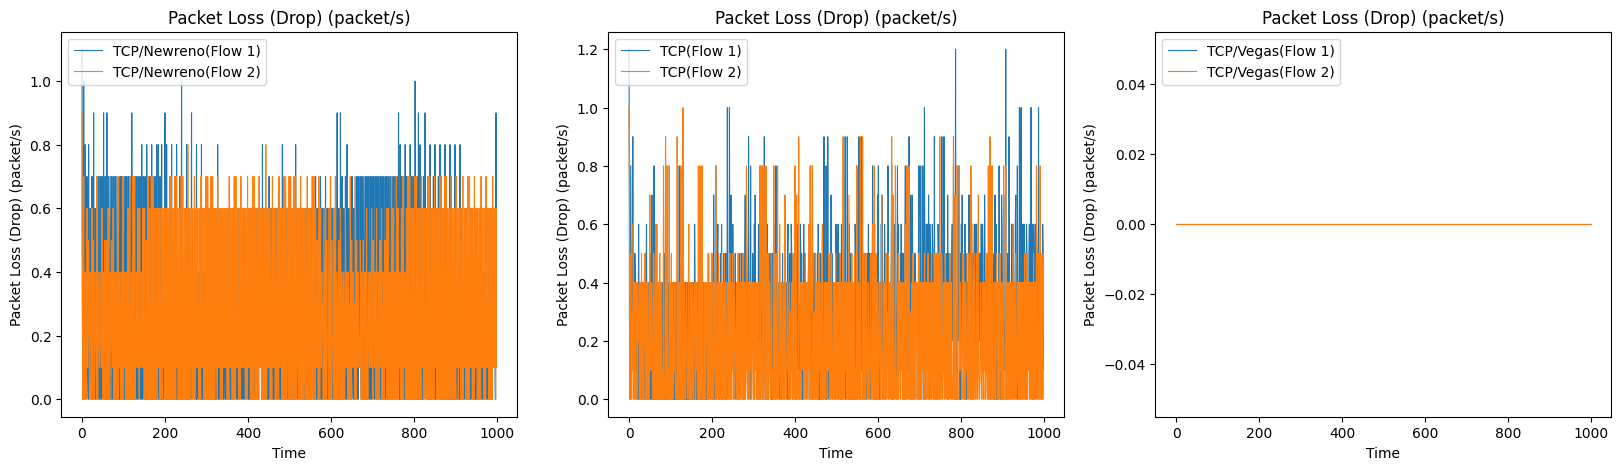

In [24]:
plotResults(dropResults, "Packet Loss (Drop) (packet/s)")

# RTT)

plotting...


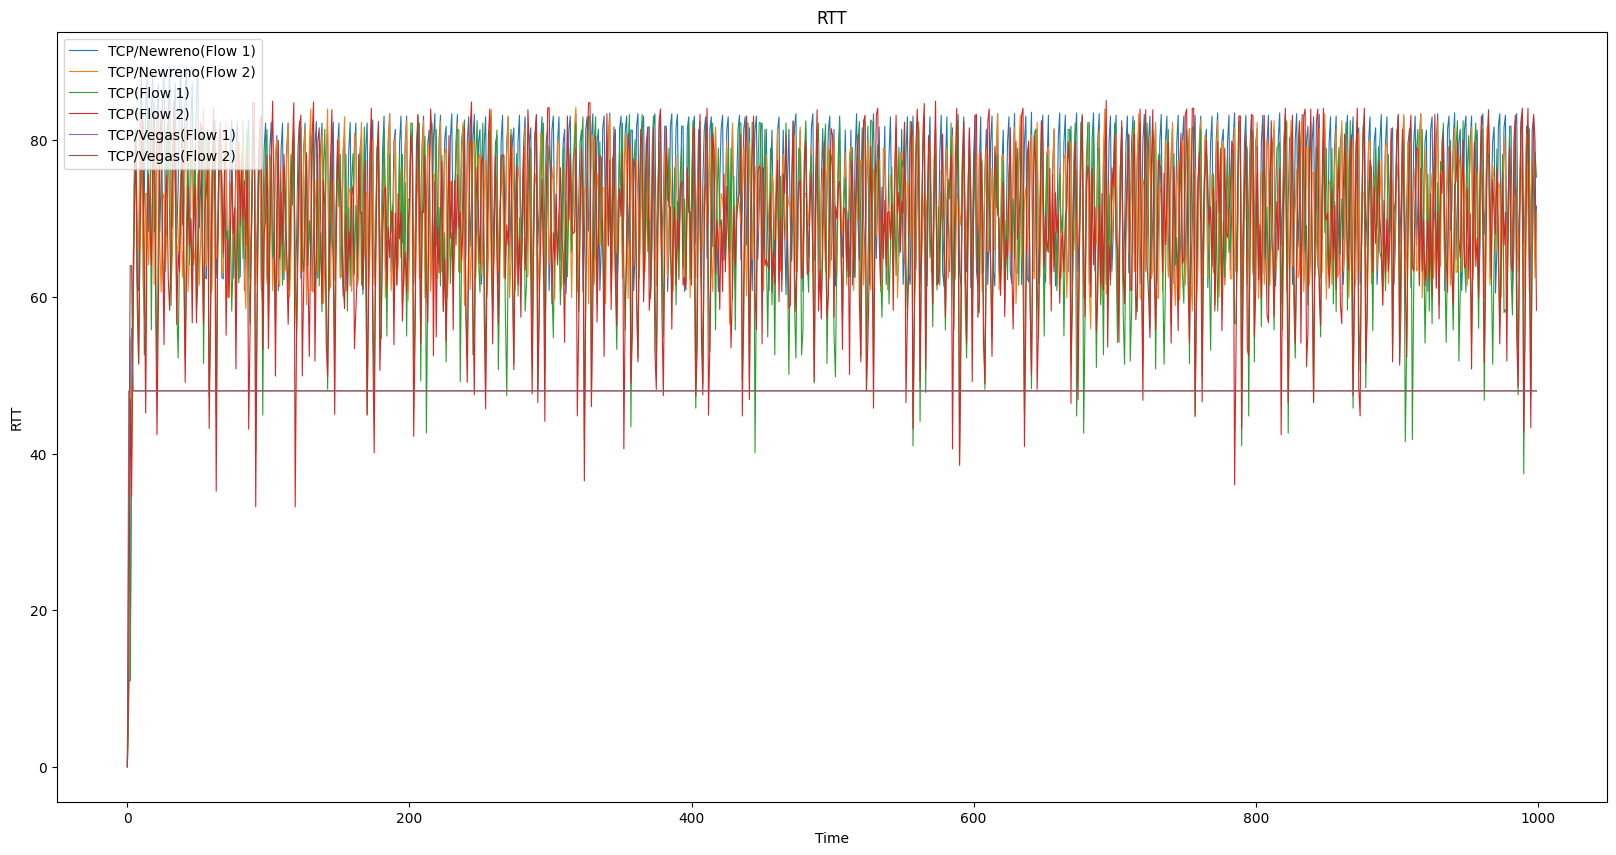

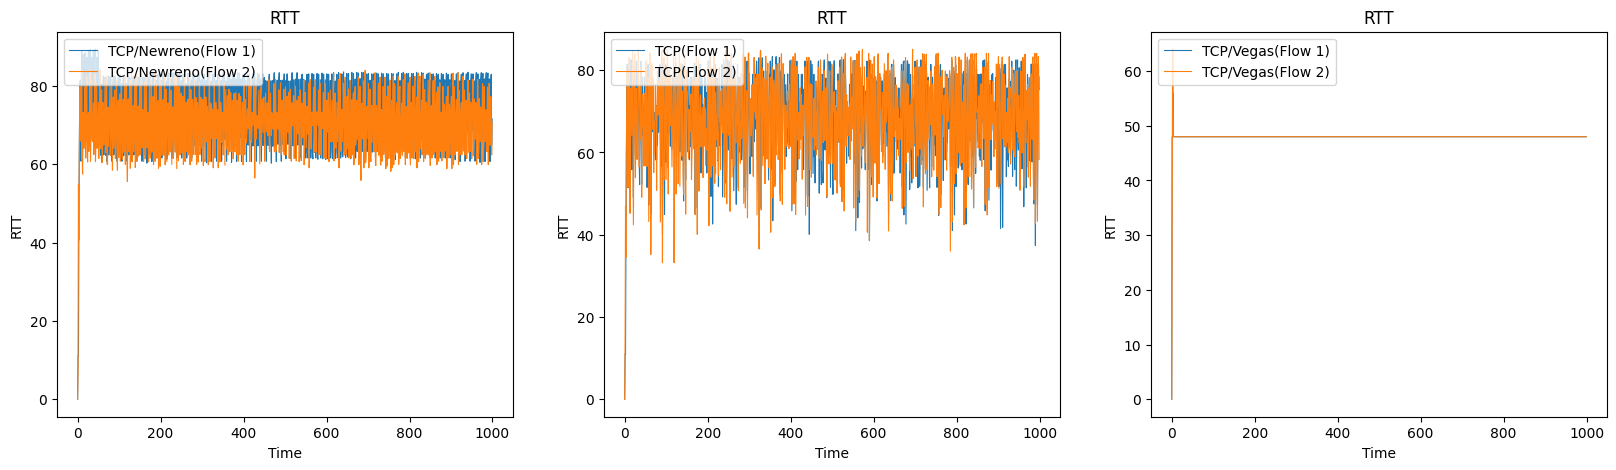

In [25]:
plotResults(rttResults, "RTT")

Sources:

https://www.isi.edu/nsnam/ns/doc/node387.html

    Agent/TCP - a ``tahoe'' TCP sender
    Agent/TCP/Reno - a ``Reno'' TCP sender
    Agent/TCP/Newreno - Reno with a modification
    Agent/TCP/Sack1 - TCP with selective repeat (follows RFC2018)
    Agent/TCP/Vegas - TCP Vegas
    Agent/TCP/Fack - Reno TCP with ``forward acknowledgment''
    Agent/TCP/Linux - a TCP sender with SACK support that runs TCP congestion control modules from Linux kernel

